# Load dataset

Імпортуємо необхідні бібліотеки

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

Імпортуємо репозиторій

In [4]:
!pip install ucimlrepo

In [5]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
drug_reviews = fetch_ucirepo(id=461)

In [6]:
print(drug_reviews.data.headers)
print(drug_reviews.data.features)

Index(['reviewID', 'urlDrugName', 'rating', 'effectiveness', 'sideEffects',
       'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview'],
      dtype='object')
           urlDrugName  rating           effectiveness            sideEffects  \
0            enalapril       4        Highly Effective      Mild Side Effects   
1     ortho-tri-cyclen       1        Highly Effective    Severe Side Effects   
2              ponstel      10        Highly Effective        No Side Effects   
3             prilosec       3    Marginally Effective      Mild Side Effects   
4               lyrica       2    Marginally Effective    Severe Side Effects   
...                ...     ...                     ...                    ...   
4138          accutane       7  Considerably Effective    Severe Side Effects   
4139        proair-hfa      10        Highly Effective        No Side Effects   
4140          accutane       8  Considerably Effective  Moderate Side Effects   
4141          

In [7]:
df = pd.DataFrame(drug_reviews.data.features)

In [8]:
df.columns

Index(['urlDrugName', 'rating', 'effectiveness', 'sideEffects', 'condition',
       'benefitsReview', 'sideEffectsReview', 'commentsReview'],
      dtype='object')

# Additional functions

In [9]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


def plot_metrics(y_test, y_pred_labels, y_pred, labels_list, num_classes):
    accuracy = accuracy_score(y_test, y_pred_labels)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred_labels)
    f1 = f1_score(y_test, y_pred_labels, average='weighted')
    precision = precision_score(y_test, y_pred_labels, average='weighted')
    recall = recall_score(y_test, y_pred_labels, average='weighted')
    confusion = confusion_matrix(y_test, y_pred_labels)

    # Print the metrics
    print("Accuracy:\t\t", accuracy)
    print("Balanced Accuracy:\t", balanced_accuracy)
    print("F1 Score:\t\t", f1)
    print("Precision:\t\t", precision)
    print("Recall:\t\t\t", recall)
    print("Confusion Matrix:\t\t")

    # Plot the confusion matrix
    plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels_list))
    plt.xticks(tick_marks, labels_list, rotation=45)
    plt.yticks(tick_marks, labels_list)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()


    # Compute ROC AUC score for each class
    roc_auc_scores_rnn = []
    for i in range(num_classes):  # Replace num_classes with the actual number of classes
        roc_auc_score_class = roc_auc_score(y_test == i, y_pred[:, i])
        roc_auc_scores_rnn.append(roc_auc_score_class)

    # Plot ROC AUC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):  # Replace num_classes with the actual number of classes
        fpr, tpr, _ = roc_curve(y_test == i, y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (class {i}, AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


In [10]:
import string
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords

def clean_text(txt):
    nltk.download('punkt')
    tokens = word_tokenize(txt)
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token.lower() for token in tokens]
    stopword_list = stopwords.words('english')
    tokens = [token for token in tokens if token not in stopword_list]
    cleaned_text = ' '.join(tokens)
    return cleaned_text

In [11]:
def plot_lc(train_loss, test_loss):
    # Plot the learning curves
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, test_loss, 'r', label='Test loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [12]:
def transform_eff(effectiveness):
    if effectiveness == 'Ineffective':
        return 'ineffective'
    elif effectiveness in ['Marginally Effective', 'Moderately Effective']:
        return 'marginally'
    elif effectiveness in ['Highly Effective', 'Considerably Effective']:
        return 'considerably'

In [13]:
def transform_sideEff(sideEffects):
    if sideEffects == 'No Side Effects':
        return 'no'
    elif sideEffects in ['Mild Side Effects', 'Moderate Side Effects']:
        return 'mild'
    elif sideEffects in ['Severe Side Effects', 'Extremely Severe Side Effects']:
        return 'severe'

# Predict overall rating

In [14]:
from sklearn.model_selection import train_test_split
import math
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

Підготуємо дані, перевівши деякі колонки в тип стрічок

In [77]:
df['sideEffectsReview'] = df['sideEffectsReview'].astype(str)
df['commentsReview'] = df['commentsReview'].astype(str)
df['condition'] = df['condition'].astype(str)
df['benefitsReview'] = df['benefitsReview'].astype(str)
df['sideEffects'] = df['sideEffects'].astype(str)
df

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,feature,sentiment,sentiment1,se,se1,benefits,benefits1
0,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed progression left ventricular dysfunctio...,cough hypotension proteinuria impotence renal ...,monitor blood pressure weight asses resolution...,slowed progression left ventricular dysfunctio...,0,negative,0,mild,0,considerably
1,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,although type birth control cons pros help cra...,heavy cycle cramps hot flashes fatigue long la...,hate birth control would suggest anyone,although type birth control cons pros help cra...,0,negative,2,severe,0,considerably
2,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,used cramps badly would leave balled bed least...,heavier bleeding clotting normal,took 2 pills onset menstrual cramps every 8-12...,used cramps badly would leave balled bed least...,2,positive,1,no,0,considerably
3,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,acid reflux went away months days drug heartbu...,constipation dry mouth mild dizziness would go...,given prilosec prescription dose 45mg per day ...,acid reflux went away months days drug heartbu...,0,negative,0,mild,2,marginally
4,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,think lyrica starting help pain side-effects s...,felt extremely drugged dopey could drive med a...,see,think lyrica starting help pain side-effects s...,0,negative,2,severe,2,marginally
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4138,accutane,7,Considerably Effective,Severe Side Effects,acne vulgaris,detoxing effect pushing system skin initially ...,hairloss extreme dry skin itchiness raises cho...,treatment period 3 months/12 weeks dosage 2 ta...,detoxing effect pushing system skin initially ...,2,positive,2,severe,0,considerably
4139,proair-hfa,10,Highly Effective,No Side Effects,asthma,albuterol relieved constriction irritation whe...,experienced side effects,use albuterol needed allergies seasonal dust e...,albuterol relieved constriction irritation whe...,2,positive,1,no,0,considerably
4140,accutane,8,Considerably Effective,Moderate Side Effects,serve acne,serve acne turned middle,painfull muscles problems seeing night,drug highly teratogenic females must take cont...,serve acne turned middle drug highly teratogen...,2,positive,0,mild,0,considerably
4141,divigel,10,Highly Effective,No Side Effects,menopause,overall mood sense well energy level increased...,side effects kind noted apparent use product u...,divigel topically applied bio-identical hormon...,overall mood sense well energy level increased...,2,positive,1,no,0,considerably


In [ ]:
text_columns = ["benefitsReview", "sideEffectsReview", "commentsReview"]
nltk.download('stopwords')
for column in text_columns:
    df[column] = df[column].apply(clean_text)

Користуючись семантичним аналізом датасету, доцільно буде об'єднати 3 колонки реценцій в 1 цілісну, для подальшого використання для передбачення

In [79]:
df['feature'] = df['benefitsReview'] + ' ' + df['commentsReview'] + ' ' + df['sideEffectsReview']

In [80]:
df['feature']

0       slowed progression left ventricular dysfunctio...
1       although type birth control cons pros help cra...
2       used cramps badly would leave balled bed least...
3       acid reflux went away months days drug heartbu...
4       think lyrica starting help pain side-effects s...
                              ...                        
4138    detoxing effect pushing system skin initially ...
4139    albuterol relieved constriction irritation whe...
4140    serve acne turned middle drug highly teratogen...
4141    overall mood sense well energy level increased...
4142    2 years ago worked really well scarring past 2...
Name: feature, Length: 4143, dtype: object

In [81]:
df

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,feature,sentiment,sentiment1,se,se1,benefits,benefits1
0,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed progression left ventricular dysfunctio...,cough hypotension proteinuria impotence renal ...,monitor blood pressure weight asses resolution...,slowed progression left ventricular dysfunctio...,0,negative,0,mild,0,considerably
1,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,although type birth control cons pros help cra...,heavy cycle cramps hot flashes fatigue long la...,hate birth control would suggest anyone,although type birth control cons pros help cra...,0,negative,2,severe,0,considerably
2,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,used cramps badly would leave balled bed least...,heavier bleeding clotting normal,took 2 pills onset menstrual cramps every 8-12...,used cramps badly would leave balled bed least...,2,positive,1,no,0,considerably
3,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,acid reflux went away months days drug heartbu...,constipation dry mouth mild dizziness would go...,given prilosec prescription dose 45mg per day ...,acid reflux went away months days drug heartbu...,0,negative,0,mild,2,marginally
4,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,think lyrica starting help pain side-effects s...,felt extremely drugged dopey could drive med a...,see,think lyrica starting help pain side-effects s...,0,negative,2,severe,2,marginally
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4138,accutane,7,Considerably Effective,Severe Side Effects,acne vulgaris,detoxing effect pushing system skin initially ...,hairloss extreme dry skin itchiness raises cho...,treatment period 3 months/12 weeks dosage 2 ta...,detoxing effect pushing system skin initially ...,2,positive,2,severe,0,considerably
4139,proair-hfa,10,Highly Effective,No Side Effects,asthma,albuterol relieved constriction irritation whe...,experienced side effects,use albuterol needed allergies seasonal dust e...,albuterol relieved constriction irritation whe...,2,positive,1,no,0,considerably
4140,accutane,8,Considerably Effective,Moderate Side Effects,serve acne,serve acne turned middle,painfull muscles problems seeing night,drug highly teratogenic females must take cont...,serve acne turned middle drug highly teratogen...,2,positive,0,mild,0,considerably
4141,divigel,10,Highly Effective,No Side Effects,menopause,overall mood sense well energy level increased...,side effects kind noted apparent use product u...,divigel topically applied bio-identical hormon...,overall mood sense well energy level increased...,2,positive,1,no,0,considerably


In [82]:
tokenizer_ = Tokenizer()
tokenizer_.fit_on_texts(df['feature'])
sequences_ = tokenizer_.texts_to_sequences(df['feature'])
padded_sequences_ = pad_sequences(sequences_, maxlen=100)

Як описано в статті, деякі класи оцінок рейтингу зустрічаються частіше ніж інші, тому доречно буде розділити їх на категорії значень 0-4, 5-7, 8-10 і позначити зберегти їх в нову колонку "відчуття" з позначками негативні, нейтральні та позитивні відповідно

In [83]:
df['sentiment'] = pd.cut(df['rating'], bins=[0, 4, 5, 10], labels=['negative', 'neutral', 'positive'], include_lowest=True)

In [84]:
df['sentiment1'] = pd.cut(df['rating'], bins=[0, 4, 5, 10], labels=['negative', 'neutral', 'positive'], include_lowest=True)

In [85]:
X = padded_sequences_.copy()
X

array([[   0,    0,    0, ...,  236, 8641,  910],
       [   0,    0,    0, ...,  107,  390,  168],
       [   0,    0,    0, ...,  501, 2964,  102],
       ...,
       [   0,    0,    0, ...,  124, 1004,   28],
       [   0,    0,    0, ...,  736,  759,  218],
       [   0,    0,    0, ...,   29,   24,   13]], dtype=int32)

In [86]:
df['sentiment'] = df['sentiment'].astype('category').cat.codes
y = df[['sentiment']].values
y

array([[0],
       [0],
       [2],
       ...,
       [2],
       [2],
       [2]], dtype=int8)

Після закінчення виконання preprocessing операцій, необхідно поділити датасет на тренувальну і тестувальну частини у співвідношенні 75% до 25% як зазначено в описі датасету

In [87]:
# Split dataset into training and testing parts (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [88]:
# Set device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# RNN

Опишемо код моделі RNN та проведемо тренування моделі

In [89]:
from tensorflow import keras
from keras import layers
import tensorflow as tf

rnn_model = keras.Sequential()

rnn_model.add(layers.Embedding(input_dim=45000, output_dim=128))
rnn_model.add(layers.SimpleRNN(units=64, input_shape=(df['sentiment'].nunique(), 1)))
rnn_model.add(layers.Dense(units=df['sentiment'].nunique(), activation='sigmoid'))

rnn_optimizer = keras.optimizers.Adam(learning_rate=0.001)

rnn_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=rnn_optimizer, metrics=['accuracy'])
rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=16)

Epoch 1/3
195/195 [==============================] - 31s 149ms/step - loss: 0.7292 - accuracy: 0.7226 - val_loss: 0.7003 - val_accuracy: 0.7268
Epoch 2/3
195/195 [==============================] - 23s 117ms/step - loss: 0.4164 - accuracy: 0.8359 - val_loss: 0.7895 - val_accuracy: 0.7085
Epoch 3/3
195/195 [==============================] - 21s 106ms/step - loss: 0.0578 - accuracy: 0.9891 - val_loss: 1.0081 - val_accuracy: 0.6998


Протестуємо модель

In [90]:
y_pred_rnn = rnn_model.predict(X_test)
y_pred_labels_rnn = np.argmax(y_pred_rnn, axis=1)

33/33 [==============================] - 1s 9ms/step


Намалюємо метрики

Accuracy:		 0.6998069498069498
Balanced Accuracy:	 0.38008211703955047
F1 Score:		 0.6592656792318232
Precision:		 0.6422512489626584
Recall:			 0.6998069498069498
Confusion Matrix:		


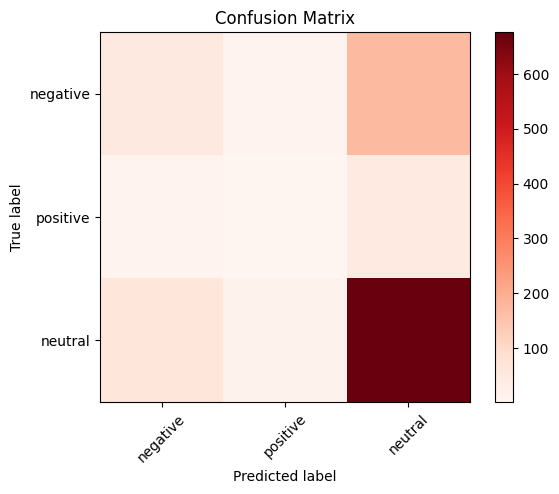

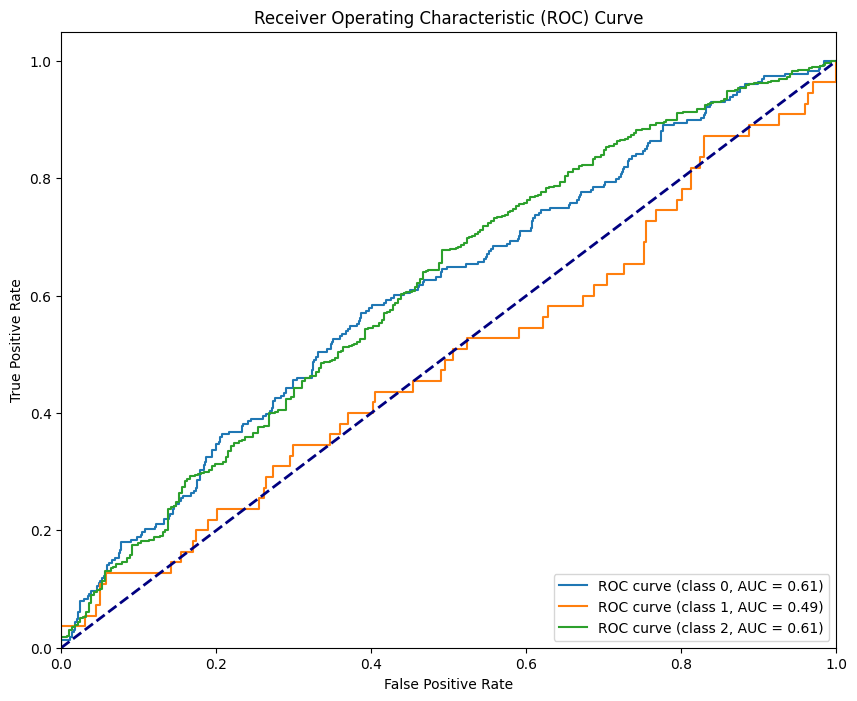

In [91]:
plot_metrics(y_test, y_pred_labels_rnn, y_pred_rnn, list(df['sentiment1'].unique()), df['sentiment'].nunique())

Намалюємо також learning curves для функції втрат

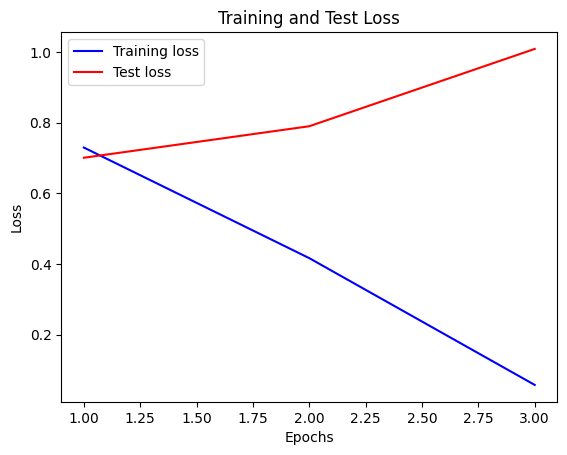

In [92]:
# Extract loss values from the history object
train_loss_rnn = rnn_history.history['loss']
val_loss_rnn = rnn_history.history['val_loss']

plot_lc(train_loss_rnn, val_loss_rnn)

# GRU

Опишемо код моделі GRU та проведемо тренування моделі

In [93]:
from tensorflow import keras
from keras import layers
import tensorflow as tf

gru_model = keras.Sequential()

gru_model.add(layers.Embedding(input_dim=45000, output_dim=128))
gru_model.add(layers.GRU(units=128, return_sequences=True))
gru_model.add(layers.Dropout(0.2))
gru_model.add(layers.GRU(units=64))
gru_model.add(layers.Dropout(0.2))
gru_model.add(layers.Dense(units=df['sentiment'].nunique(), activation='softmax'))

gru_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

gru_model.compile(optimizer=gru_optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

gru_history = gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=16)

Epoch 1/3
195/195 [==============================] - 23s 85ms/step - loss: 0.6909 - accuracy: 0.7403 - val_loss: 0.6367 - val_accuracy: 0.7606
Epoch 2/3
195/195 [==============================] - 8s 42ms/step - loss: 0.4506 - accuracy: 0.8394 - val_loss: 0.7096 - val_accuracy: 0.7683
Epoch 3/3
195/195 [==============================] - 6s 33ms/step - loss: 0.2167 - accuracy: 0.9263 - val_loss: 0.8727 - val_accuracy: 0.7288


Протестуємо модель

In [94]:
y_pred_gru = gru_model.predict(X_test)
y_pred_labels_gru = np.argmax(y_pred_gru, axis=1)

33/33 [==============================] - 1s 7ms/step


Намалюємо метрики та learning curves

Accuracy:		 0.7287644787644788
Balanced Accuracy:	 0.47184955023076225
F1 Score:		 0.7181437947954041
Precision:		 0.7112974581724582
Recall:			 0.7287644787644788
Confusion Matrix:		


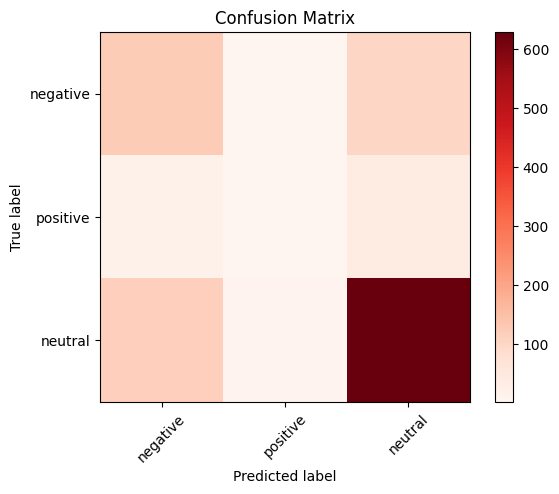

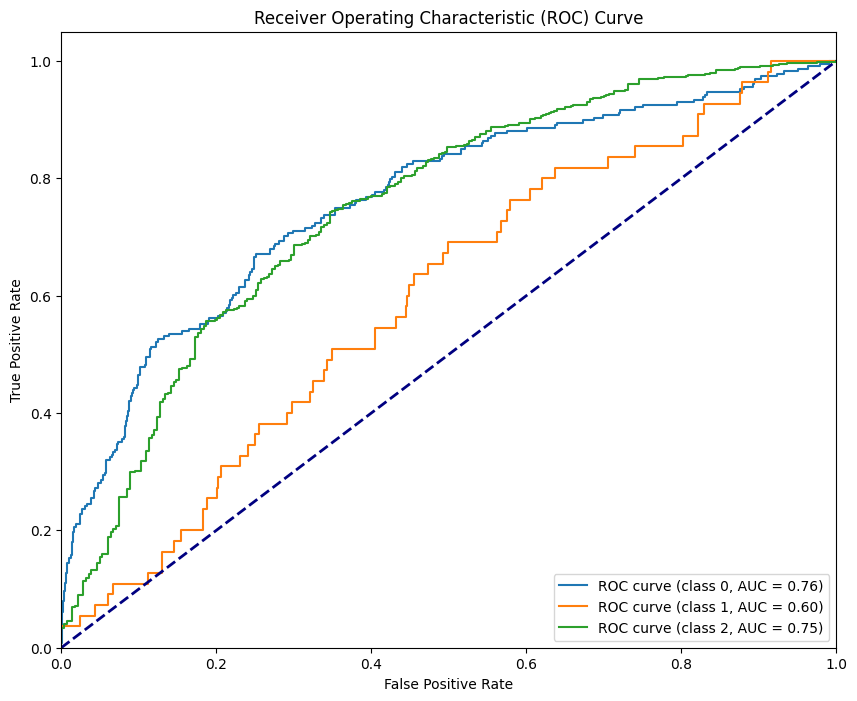

In [95]:
plot_metrics(y_test, y_pred_labels_gru, y_pred_gru, list(df['sentiment1'].unique()), df['sentiment'].nunique())

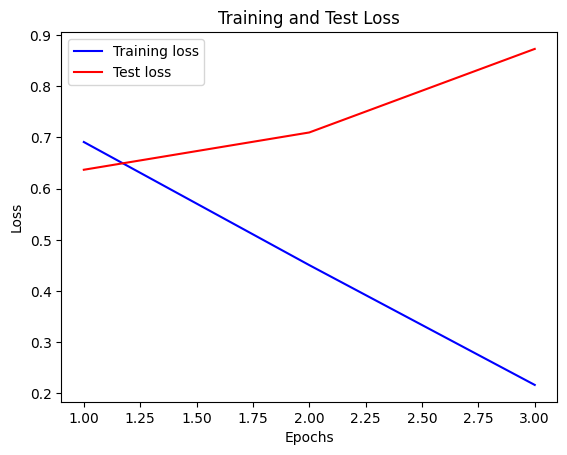

In [96]:
# Extract loss values from the history object
train_loss_lstm = gru_history.history['loss']
val_loss_lstm = gru_history.history['val_loss']

plot_lc(train_loss_lstm, val_loss_lstm)

# LSTM

Опишемо код моделі LSTM та проведемо тренування моделі

In [97]:
# Create a sequential model
lstm_model = keras.Sequential()

# Add an embedding layer with 15,000 input dimensions and 128 output dimensions
lstm_model.add(layers.Embedding(input_dim=45000, output_dim=128))
# Add an LSTM layer with 128 units, set to return sequences
lstm_model.add(layers.LSTM(128, return_sequences=True))
# Add another LSTM layer with 64 units
lstm_model.add(layers.LSTM(64))
# Add a dense layer with 10 units (for 10 classes)
lstm_model.add(layers.Dense(df['sentiment'].nunique(), activation='softmax'))

# Define the Adam optimizer with a learning rate of 0.001
lstm_optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Compile the model with SparseCategoricalCrossentropy loss and Adam optimizer
lstm_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=lstm_optimizer, metrics=['accuracy'])

# Train the model using X_train and y_train, and validate using X_test and y_test
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=16)

Epoch 1/3
195/195 [==============================] - 19s 81ms/step - loss: 0.6765 - accuracy: 0.7457 - val_loss: 0.6590 - val_accuracy: 0.7452
Epoch 2/3
195/195 [==============================] - 9s 44ms/step - loss: 0.4015 - accuracy: 0.8664 - val_loss: 0.6694 - val_accuracy: 0.7606
Epoch 3/3
195/195 [==============================] - 5s 27ms/step - loss: 0.2000 - accuracy: 0.9298 - val_loss: 1.0055 - val_accuracy: 0.7732


Протестуємо модель

In [98]:
y_pred_lstm = lstm_model.predict(X_test)
y_pred_labels_lstm = np.argmax(y_pred_lstm, axis=1)

33/33 [==============================] - 1s 7ms/step


Намалюємо метрики та learning curves

Accuracy:		 0.7731660231660231
Balanced Accuracy:	 0.4544979041833728
F1 Score:		 0.737758838366741
Precision:		 0.7342203364196243
Recall:			 0.7731660231660231
Confusion Matrix:		


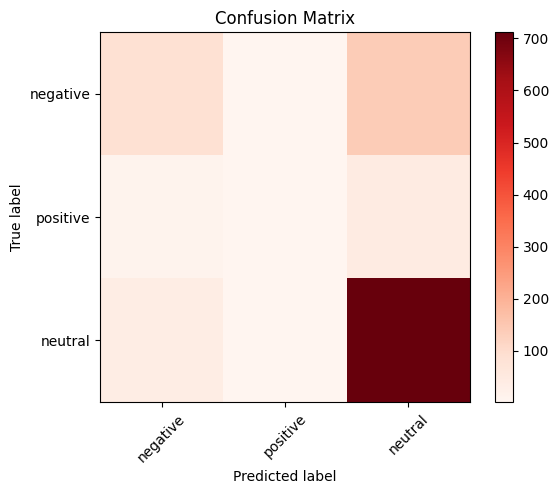

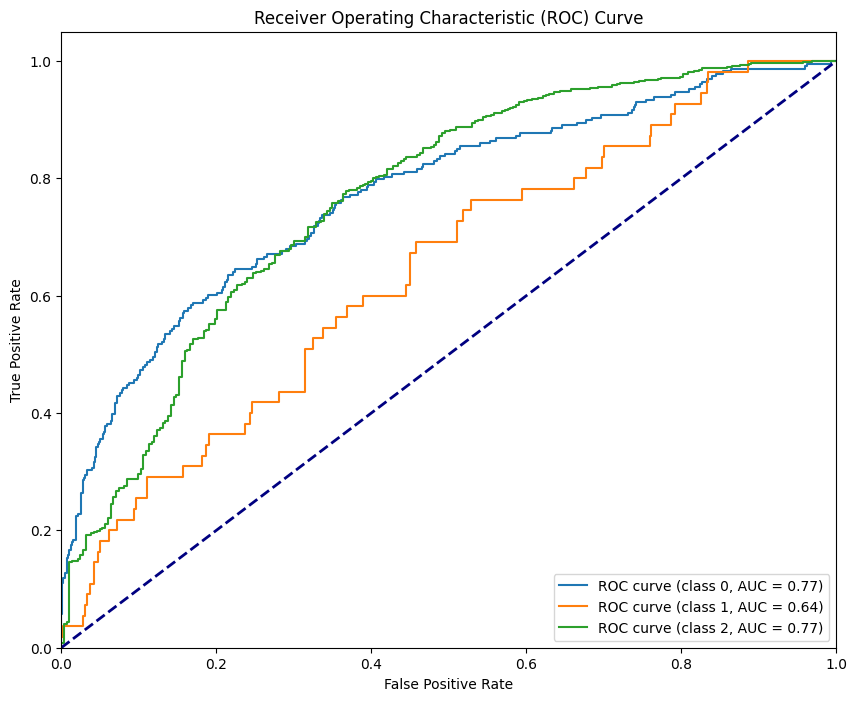

In [99]:
plot_metrics(y_test, y_pred_labels_lstm, y_pred_lstm, list(df['sentiment1'].unique()), df['sentiment'].nunique())

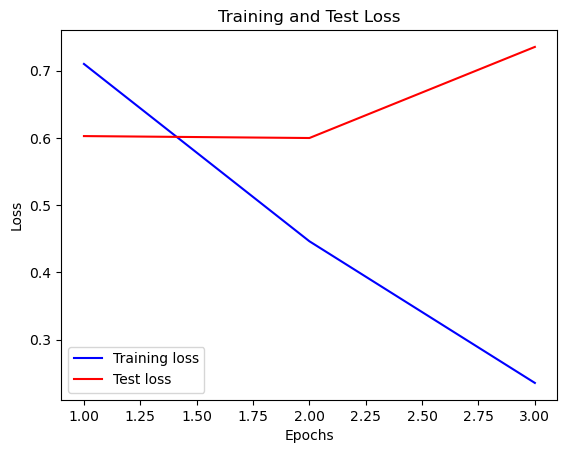

In [ ]:
# Extract loss values from the history object
train_loss_lstm = lstm_history.history['loss']
val_loss_lstm = lstm_history.history['val_loss']

plot_lc(train_loss_lstm, val_loss_lstm)

# GPT

In [ ]:
from transformers import GPT2Tokenizer, GPT2Model

gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
gpt_tokenizer.pad_token = '[PAD]'

gpt_model = GPT2Model.from_pretrained('gpt2').to(device)
gpt_model.resize_token_embeddings(len(gpt_tokenizer))

X_train_gpt, X_test_gpt, y_train_gpt, y_test_gpt = train_test_split(df['feature'], df['sentiment'], test_size=0.25, shuffle=True)

train_inputs_gpt = gpt_tokenizer([str(i) for i in X_train_gpt.values] , return_tensors='pt', truncation=True, padding="max_length", max_length=512)
test_inputs_gpt = gpt_tokenizer([str(i) for i in X_test_gpt.values], return_tensors='pt', truncation=True, padding="max_length", max_length=512)
y_train_gpt_ = pd.get_dummies(y_train_gpt).values
y_test_gpt_ = pd.get_dummies(y_test_gpt).values


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
y_train_labels_gpt = np.argmax(y_train_gpt_, axis=1)
y_test_labels_gpt = np.argmax(y_test_gpt_, axis=1)
y_train_tensor_gpt = torch.tensor(y_train_labels_gpt).long()
y_test_tensor_gpt = torch.tensor(y_test_labels_gpt).long()

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import GradScaler, autocast

tensor_datasets_gpt = [
    TensorDataset(train_inputs_gpt['input_ids'], train_inputs_gpt['attention_mask'], y_train_tensor_gpt),
    TensorDataset(test_inputs_gpt['input_ids'], test_inputs_gpt['attention_mask'], y_test_tensor_gpt)
]

loader_gpt = [
    DataLoader(tensor_datasets_gpt[0], batch_size=4, shuffle=True, num_workers=2),
    DataLoader(tensor_datasets_gpt[1], batch_size=4, num_workers=2)
]



In [58]:
class GPT2(nn.Module):
    def __init__(self, gpt2_model, num_labels):
        super(GPT2, self).__init__()
        self.gpt2 = gpt2_model
        self.classifier = nn.Linear(self.gpt2.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[0][:, 0, :]  # Take the pooled output (CLS token)
        logits = self.classifier(pooled_output)
        return logits

In [40]:
def run_model(model, train_loader, test_loader, optimizer, criterion, scaler, num_epochs):
    model.to(device)
    train_losses = []
    test_losses = []
    y_train_pred = []
    y_test_pred = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        predictions_train = []
        true_labels_train = []
        for input_ids, attention_mask, targets in train_loader:
            input_ids, attention_mask, targets = input_ids.to(device), attention_mask.to(device), targets.to(device)
            optimizer.zero_grad()
            with autocast():
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            predictions_train.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels_train.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        predictions_test = []
        true_labels_test = []
        with torch.no_grad():
            for input_ids, attention_mask, targets in test_loader:
                input_ids, attention_mask, targets = input_ids.to(device), attention_mask.to(device), targets.to(device)
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, targets)
                test_loss += loss.item()
                predictions_test.extend(torch.argmax(logits, dim=1).cpu().numpy())
                true_labels_test.extend(targets.cpu().numpy())

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        accuracy_train = accuracy_score(true_labels_train, predictions_train)
        accuracy_test = accuracy_score(true_labels_test, predictions_test)
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {accuracy_train:.4f}, Test Accuracy: {accuracy_test:.4f}')

        y_train_pred = np.array(predictions_train)
        y_test_pred = np.array(predictions_test)

    return train_losses, test_losses, y_train_pred, y_test_pred


In [41]:
def evaluate_model(model, test_dataloader, device, labels_list, num_classes):
    true_labels = []
    predicted_labels = []
    predicted_logits = []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]
            logits = model(input_ids, attention_mask)
            _, predicted = torch.max(logits, dim=1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            predicted_logits.extend(logits.cpu().numpy())

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    predicted_logits = np.array(predicted_logits)

    plot_metrics(true_labels, predicted_labels, predicted_logits, labels_list, num_classes)

In [ ]:
from torch.cuda.amp import GradScaler

torch.cuda.empty_cache()
model = GPT2(gpt_model, df['sentiment'].nunique()).to(device)
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()
train_loss, test_loss, y_train_pred, y_test_pred = run_model(model, loader_gpt[0], loader_gpt[1], optimizer, criterion, scaler, 2)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/2, Train Loss: 0.7460, Test Loss: 0.7583, Train Accuracy: 0.7422, Test Accuracy: 0.7355


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/2, Train Loss: 0.6911, Test Loss: 0.7241, Train Accuracy: 0.7615, Test Accuracy: 0.7346


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:		 0.7345559845559846
Balanced Accuracy:	 0.381551845876366
F1 Score:		 0.650877427539664
Precision:		 0.7335038028562125
Recall:			 0.7345559845559846
Confusion Matrix:		


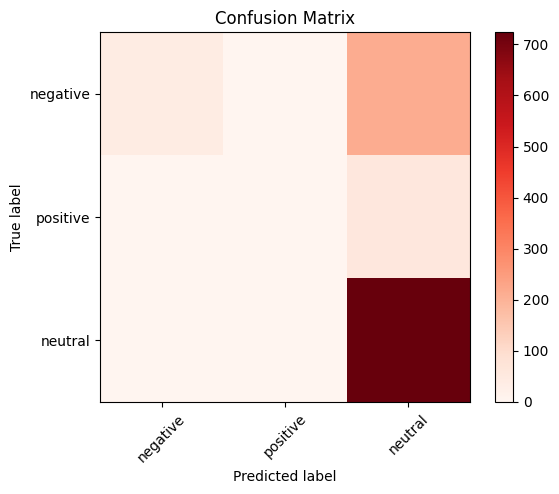

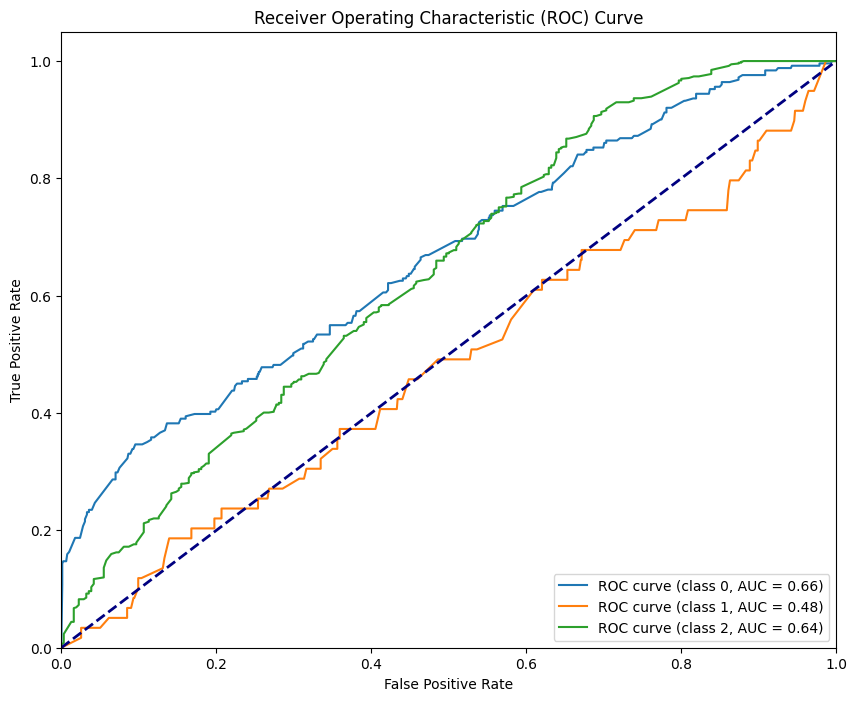

In [ ]:
evaluate_model(model, loader_gpt[1], device, list(df['sentiment1'].unique()), df['sentiment'].nunique())
torch.cuda.empty_cache()

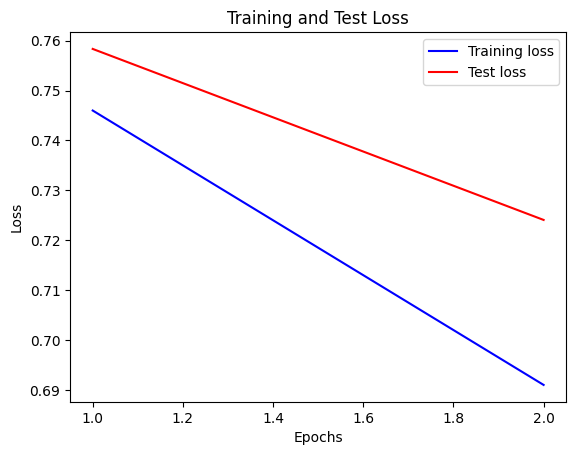

In [ ]:
plot_lc(train_loss, test_loss)

# BERT

In [ ]:
from transformers import AutoTokenizer, BertModel, BertTokenizer

tokenizerBERT = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(df['feature'], df['sentiment'], test_size=0.25, shuffle=True)

train_encodings_bert = tokenizerBERT(list(X_train_bert), truncation=True, padding=True, return_tensors='pt')
test_encodings_bert = tokenizerBERT(list(X_test_bert), truncation=True, padding=True, return_tensors='pt')
y_train_bert_ = pd.get_dummies(y_train_bert).values
y_test_bert_ = pd.get_dummies(y_test_bert).values

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
y_train_tensor_bert = torch.tensor(np.argmax(y_train_bert_, axis=1)).long()
y_test_tensor_bert = torch.tensor(np.argmax(y_test_bert_, axis=1)).long()

In [ ]:
tensor_datasets_bert =  [
    TensorDataset(train_encodings_bert['input_ids'], train_encodings_bert['attention_mask'], y_train_tensor_bert),
    TensorDataset(test_encodings_bert['input_ids'], test_encodings_bert['attention_mask'], y_test_tensor_bert)
]

loader_bert = [
    DataLoader(tensor_datasets_bert[0], batch_size=4, shuffle=True, num_workers=2),
    DataLoader(tensor_datasets_bert[1], batch_size=4, num_workers=2)
]

In [42]:
class BERT(nn.Module):
    def __init__(self, bert_model, num_labels):
        super(BERT, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [ ]:
from torch.cuda.amp import GradScaler

torch.cuda.empty_cache()
model = BERT(bert_model, df['sentiment'].nunique()).to(device)
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()
train_loss, test_loss, y_train_pred, y_test_pred = run_model(model, loader_bert[0], loader_bert[1], optimizer, criterion, scaler, 2)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/2, Train Loss: 0.8329, Test Loss: 0.8044, Train Accuracy: 0.6852, Test Accuracy: 0.7297


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/2, Train Loss: 0.8323, Test Loss: 0.8377, Train Accuracy: 0.6759, Test Accuracy: 0.7297


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:		 0.7297297297297297
Balanced Accuracy:	 0.3333333333333333
F1 Score:		 0.6157094594594593
Precision:		 0.5325054784514244
Recall:			 0.7297297297297297
Confusion Matrix:		


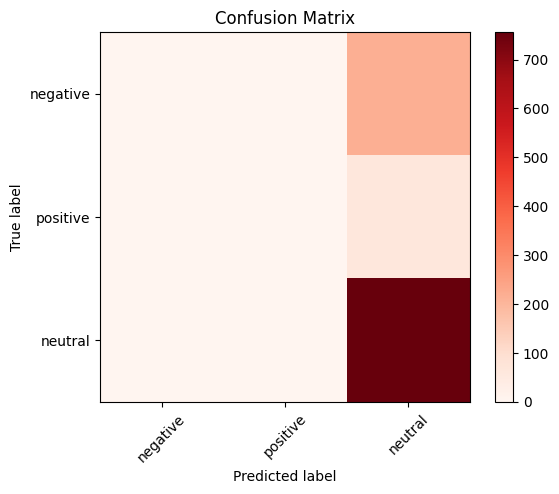

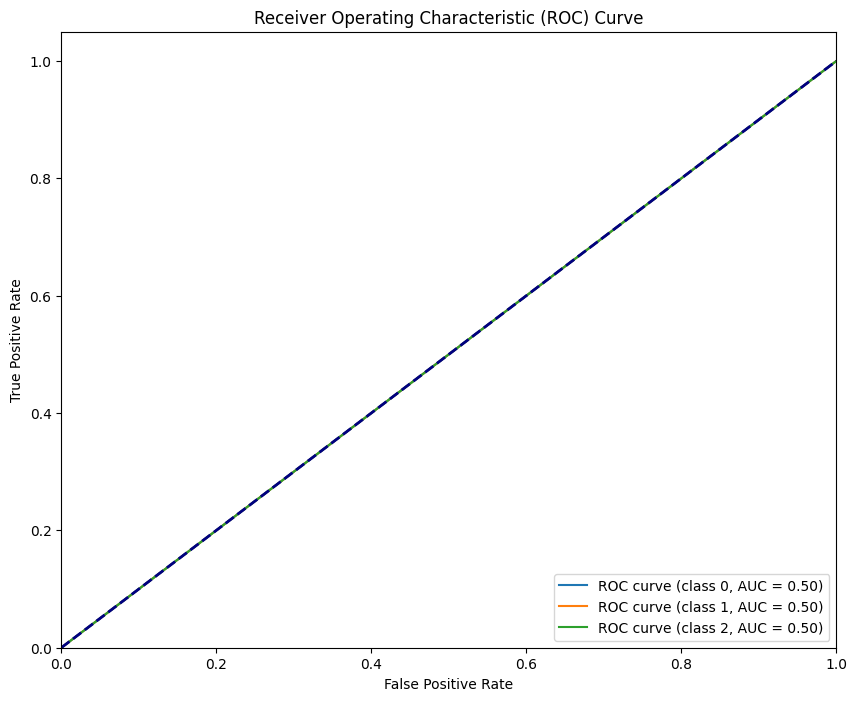

In [ ]:
evaluate_model(model, loader_bert[1], device, list(df['sentiment1'].unique()), df['sentiment'].nunique())
torch.cuda.empty_cache()

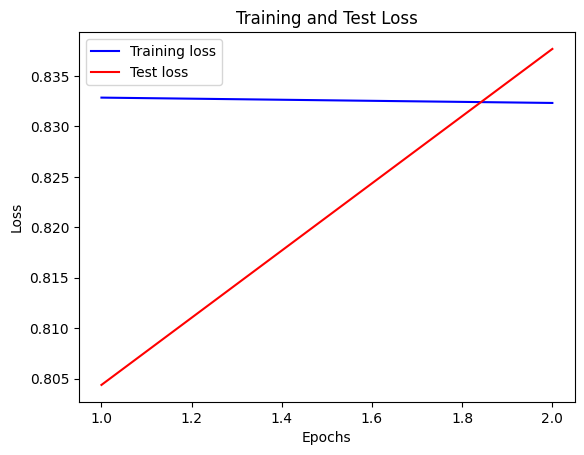

In [ ]:
plot_lc(train_loss, test_loss)

# Predict effectiveness/Benefits

Надалі, для передбачення наступних ознак, будемо використовувати лише відповідні їм поля рецензій, користуючись інформацією з семантичного аналізу, проведеного над датасетом.

In [101]:
tokenizer_ = Tokenizer()
tokenizer_.fit_on_texts(df['benefitsReview'])
sequences_ = tokenizer_.texts_to_sequences(df['benefitsReview'])
padded_sequences_ = pad_sequences(sequences_, maxlen=100)

In [102]:
X = padded_sequences_.copy()

З опису датасету зрозуміло, що для передбачення ознаки ефективність, її краще розділити на 3 класи, замість наявних 5, що має допомогти збільшити точність

In [103]:
df['benefits'] = df['effectiveness'].apply(transform_eff)

In [104]:
df['benefits1'] = df['benefits']
df['benefits1'].unique()

array(['considerably', 'marginally', 'ineffective'], dtype=object)

In [105]:
df['benefits'] = df['benefits'].astype('category').cat.codes
y = df[['benefits']].values
y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int8)

Після закінчення виконання preprocessing операцій, необхідно поділити датасет на тренувальну і тестувальну частини у співвідношенні 75% до 25% як зазначено в описі датасету

In [106]:
# Split dataset into training and testing parts (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

# RNN

In [109]:
rnn_model = keras.Sequential()

rnn_model.add(layers.Embedding(input_dim=15000, output_dim=128))
rnn_model.add(layers.SimpleRNN(units=64, input_shape=(df['benefits'].nunique(), 1)))
rnn_model.add(layers.Dense(units=df['benefits'].nunique(), activation='softmax'))

rnn_optimizer = keras.optimizers.Adam(learning_rate=0.001)

rnn_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=rnn_optimizer, metrics=['accuracy'])
rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=16)

Epoch 1/3
195/195 [==============================] - 35s 173ms/step - loss: 0.7733 - accuracy: 0.7145 - val_loss: 0.7643 - val_accuracy: 0.7162
Epoch 2/3
195/195 [==============================] - 22s 115ms/step - loss: 0.4290 - accuracy: 0.8349 - val_loss: 0.8347 - val_accuracy: 0.6573
Epoch 3/3
195/195 [==============================] - 20s 101ms/step - loss: 0.1112 - accuracy: 0.9659 - val_loss: 0.9270 - val_accuracy: 0.6834


In [110]:
y_pred_rnn = rnn_model.predict(X_test)
y_pred_labels_rnn = np.argmax(y_pred_rnn, axis=1)

33/33 [==============================] - 0s 9ms/step


Accuracy:		 0.6833976833976834
Balanced Accuracy:	 0.451855638520614
F1 Score:		 0.649235273420914
Precision:		 0.642030338747279
Recall:			 0.6833976833976834
Confusion Matrix:		


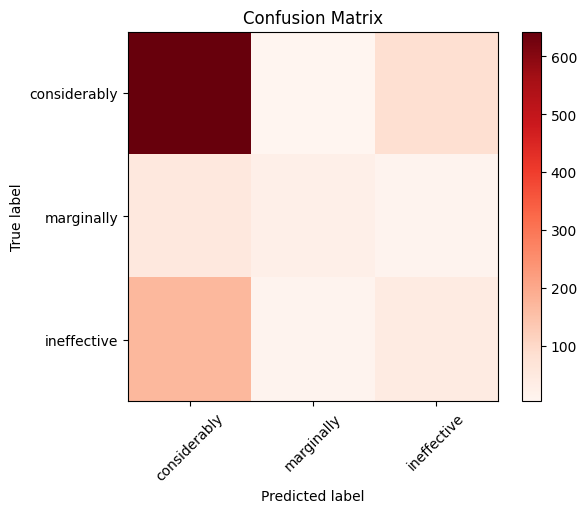

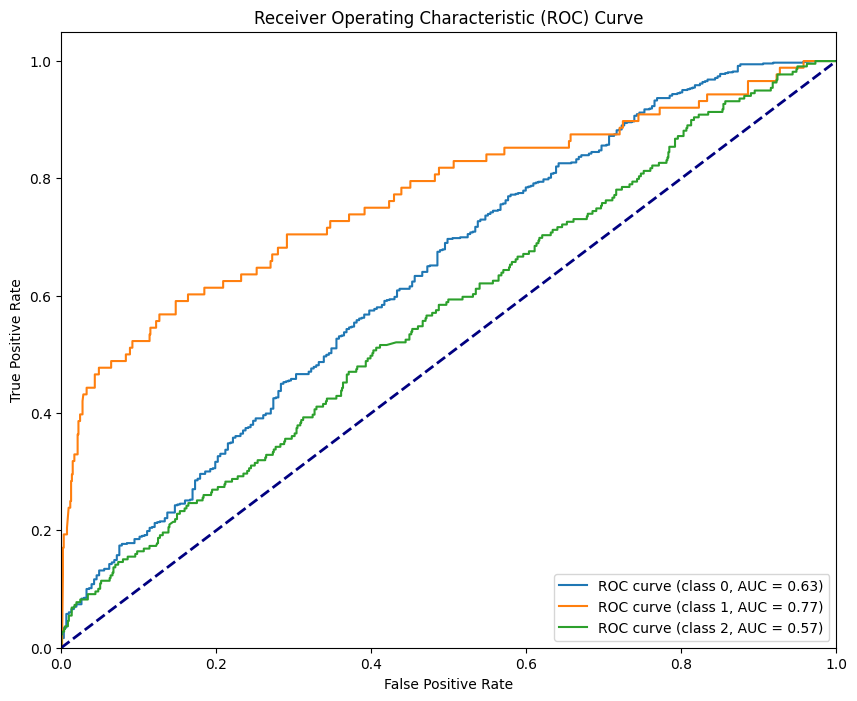

In [111]:
plot_metrics(y_test, y_pred_labels_rnn, y_pred_rnn, list(df['benefits1'].unique()), df['benefits'].nunique())

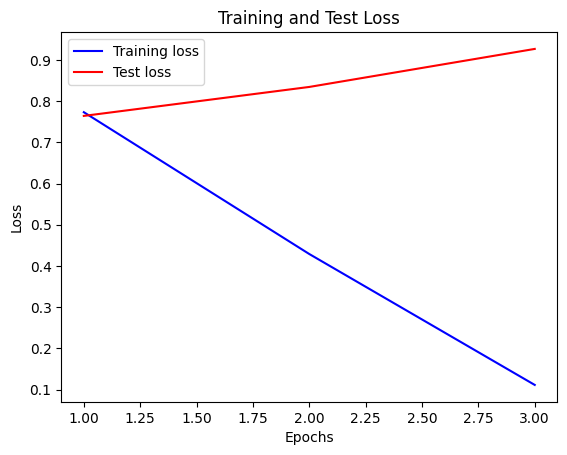

In [112]:
# Extract loss values from the history object
train_loss_rnn = rnn_history.history['loss']
val_loss_rnn = rnn_history.history['val_loss']

plot_lc(train_loss_rnn, val_loss_rnn)

# GRU

In [113]:
from tensorflow import keras
from keras import layers
import tensorflow as tf

gru_model = keras.Sequential()

gru_model.add(layers.Embedding(input_dim=15000, output_dim=128))
gru_model.add(layers.GRU(128, return_sequences=True))
gru_model.add(layers.Dropout(0.2))
gru_model.add(layers.GRU(64))
gru_model.add(layers.Dropout(0.2))
gru_model.add(layers.Dense(df['benefits'].nunique(), activation='softmax'))

gru_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

gru_model.compile(optimizer=gru_optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

gru_history = gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=16)

Epoch 1/3
195/195 [==============================] - 19s 76ms/step - loss: 0.7211 - accuracy: 0.7383 - val_loss: 0.7033 - val_accuracy: 0.7249
Epoch 2/3
195/195 [==============================] - 7s 35ms/step - loss: 0.5106 - accuracy: 0.7914 - val_loss: 0.7043 - val_accuracy: 0.7326
Epoch 3/3
195/195 [==============================] - 6s 29ms/step - loss: 0.2919 - accuracy: 0.8919 - val_loss: 0.9573 - val_accuracy: 0.6834


In [114]:
y_pred_gru = gru_model.predict(X_test)
y_pred_labels_gru = np.argmax(y_pred_gru, axis=1)

33/33 [==============================] - 1s 6ms/step


Accuracy:		 0.6833976833976834
Balanced Accuracy:	 0.5089720560928069
F1 Score:		 0.6788630529587598
Precision:		 0.6821964024118952
Recall:			 0.6833976833976834
Confusion Matrix:		


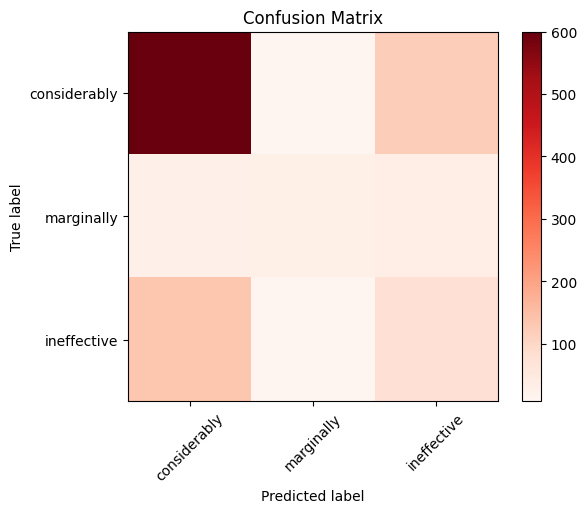

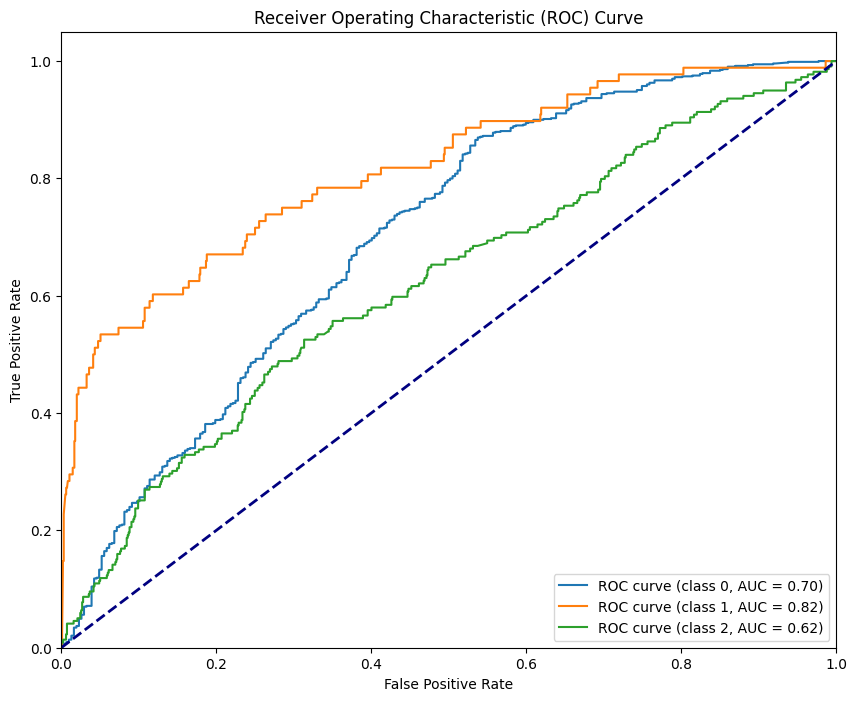

In [115]:
plot_metrics(y_test, y_pred_labels_gru, y_pred_gru, list(df['benefits1'].unique()), df['benefits'].nunique())

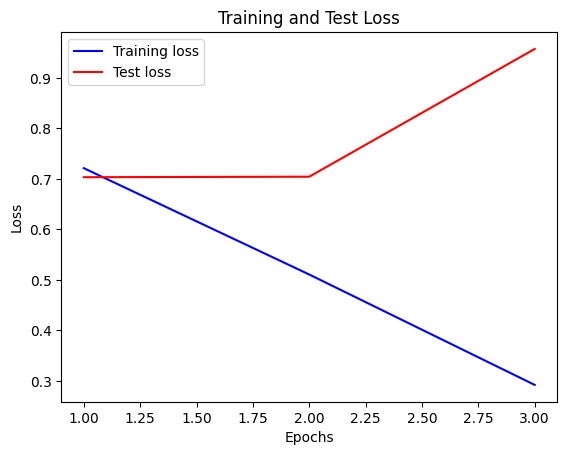

In [116]:
# Extract loss values from the history object
train_loss_lstm = gru_history.history['loss']
val_loss_lstm = gru_history.history['val_loss']

plot_lc(train_loss_lstm, val_loss_lstm)

# LSTM

In [117]:
from tensorflow import keras
from keras import layers
import tensorflow as tf

# Create a sequential model
lstm_model = keras.Sequential()

# Add an embedding layer with 15,000 input dimensions and 128 output dimensions
lstm_model.add(layers.Embedding(input_dim=15000, output_dim=128))
# Add an LSTM layer with 128 units, set to return sequences
lstm_model.add(layers.LSTM(128, return_sequences=True))
# Add another LSTM layer with 64 units
lstm_model.add(layers.LSTM(64))
# Add a dense layer with 5 units (for 5 classes)
lstm_model.add(layers.Dense(df['benefits'].nunique(), activation='softmax'))

# Define the Adam optimizer with a learning rate of 0.001
lstm_optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Compile the model with SparseCategoricalCrossentropy loss and Adam optimizer
lstm_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=lstm_optimizer, metrics=['accuracy'])

# Train the model using X_train and y_train, and validate using X_test and y_test
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=16)

Epoch 1/3
195/195 [==============================] - 19s 81ms/step - loss: 0.7314 - accuracy: 0.7261 - val_loss: 0.6952 - val_accuracy: 0.7278
Epoch 2/3
195/195 [==============================] - 7s 36ms/step - loss: 0.5190 - accuracy: 0.7850 - val_loss: 0.6992 - val_accuracy: 0.7355
Epoch 3/3
195/195 [==============================] - 5s 26ms/step - loss: 0.3068 - accuracy: 0.8828 - val_loss: 0.8654 - val_accuracy: 0.7278


In [118]:
y_pred_lstm = lstm_model.predict(X_test)
y_pred_labels_lstm = np.argmax(y_pred_lstm, axis=1)

33/33 [==============================] - 1s 6ms/step


Accuracy:		 0.7277992277992278
Balanced Accuracy:	 0.5349455431478094
F1 Score:		 0.7078544623818649
Precision:		 0.7021095624081056
Recall:			 0.7277992277992278
Confusion Matrix:		


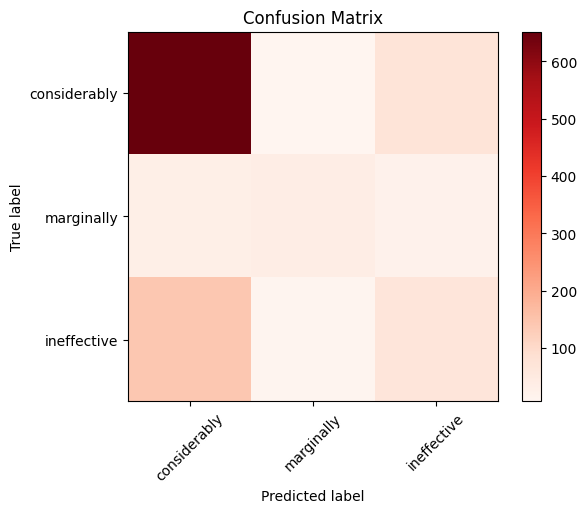

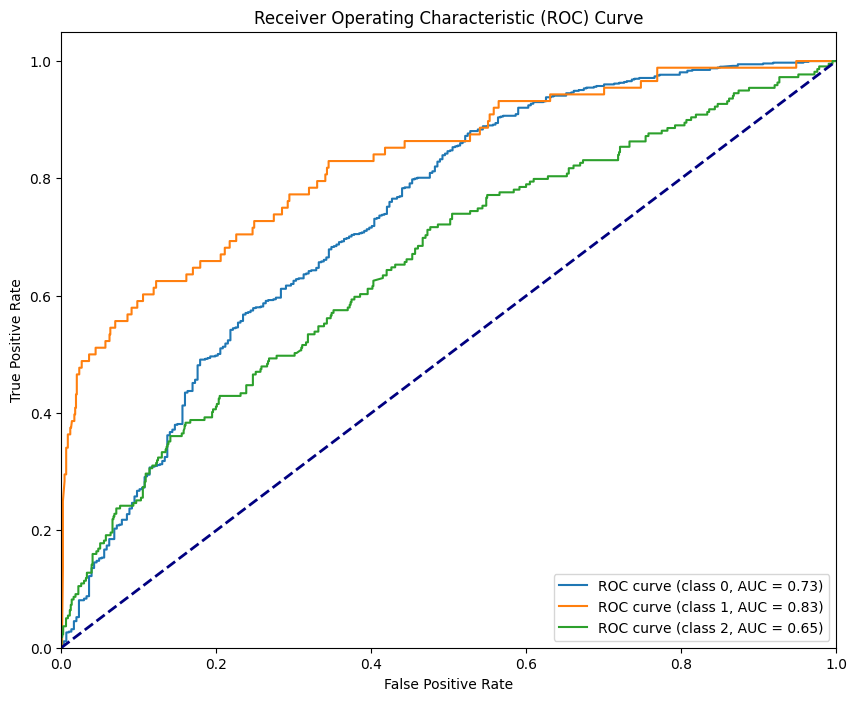

In [119]:
plot_metrics(y_test, y_pred_labels_lstm, y_pred_lstm, list(df['benefits1'].unique()), df['benefits'].nunique())

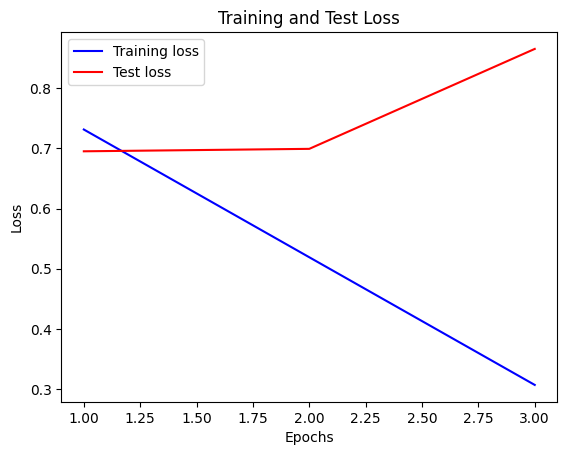

In [120]:
# Extract loss values from the history object
train_loss_lstm = lstm_history.history['loss']
val_loss_lstm = lstm_history.history['val_loss']

plot_lc(train_loss_lstm, val_loss_lstm)

# GPT

In [52]:
from transformers import GPT2Tokenizer, GPT2Model

gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
gpt_tokenizer.pad_token = '[PAD]'

gpt_model = GPT2Model.from_pretrained('gpt2').to(device)
gpt_model.resize_token_embeddings(len(gpt_tokenizer))

X_train_gpt, X_test_gpt, y_train_gpt, y_test_gpt = train_test_split(df['benefitsReview'], df['benefits'], test_size=0.25, shuffle=True)

train_inputs_gpt = gpt_tokenizer([str(i) for i in X_train_gpt.values] , return_tensors='pt', truncation=True, padding="max_length", max_length=512)
test_inputs_gpt = gpt_tokenizer([str(i) for i in X_test_gpt.values], return_tensors='pt', truncation=True, padding="max_length", max_length=512)
y_train_gpt_ = pd.get_dummies(y_train_gpt).values
y_test_gpt_ = pd.get_dummies(y_test_gpt).values


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [53]:
y_train_labels_gpt = np.argmax(y_train_gpt_, axis=1)
y_test_labels_gpt = np.argmax(y_test_gpt_, axis=1)
y_train_tensor_gpt = torch.tensor(y_train_labels_gpt).long()
y_test_tensor_gpt = torch.tensor(y_test_labels_gpt).long()

In [54]:
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import GradScaler, autocast

tensor_datasets_gpt = [
    TensorDataset(train_inputs_gpt['input_ids'], train_inputs_gpt['attention_mask'], y_train_tensor_gpt),
    TensorDataset(test_inputs_gpt['input_ids'], test_inputs_gpt['attention_mask'], y_test_tensor_gpt)
]

loader_gpt = [
    DataLoader(tensor_datasets_gpt[0], batch_size=4, shuffle=True, num_workers=2),
    DataLoader(tensor_datasets_gpt[1], batch_size=4, num_workers=2)
]



In [59]:
from torch.cuda.amp import GradScaler

torch.cuda.empty_cache()
model = GPT2(gpt_model, df['benefits'].nunique()).to(device)
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()
train_loss, test_loss, y_train_pred, y_test_pred = run_model(model, loader_gpt[0], loader_gpt[1], optimizer, criterion, scaler, 2)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/2, Train Loss: 0.8073, Test Loss: 0.7051, Train Accuracy: 0.7222, Test Accuracy: 0.7539


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/2, Train Loss: 0.7338, Test Loss: 0.7587, Train Accuracy: 0.7232, Test Accuracy: 0.7365


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:		 0.7364864864864865
Balanced Accuracy:	 0.3333333333333333
F1 Score:		 0.624723945735619
Precision:		 0.5424123447772096
Recall:			 0.7364864864864865
Confusion Matrix:		


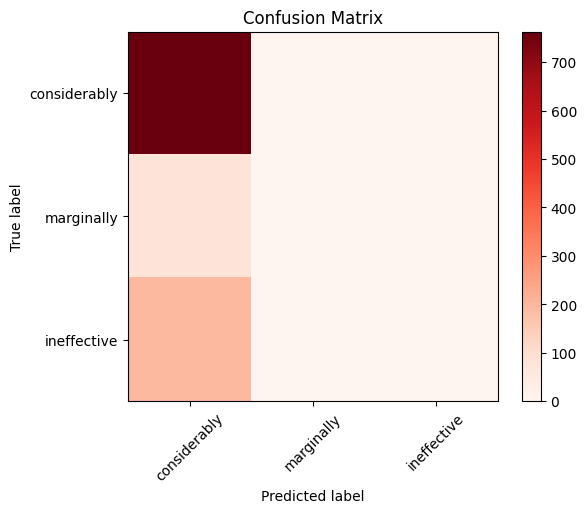

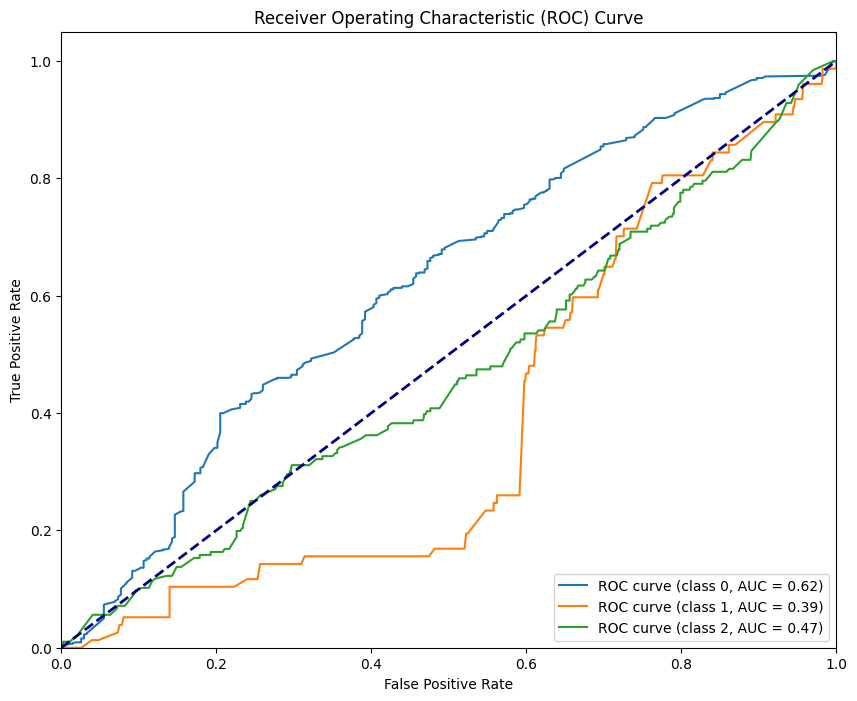

In [60]:
evaluate_model(model, loader_gpt[1], device, list(df['benefits1'].unique()), df['benefits'].nunique())
torch.cuda.empty_cache()

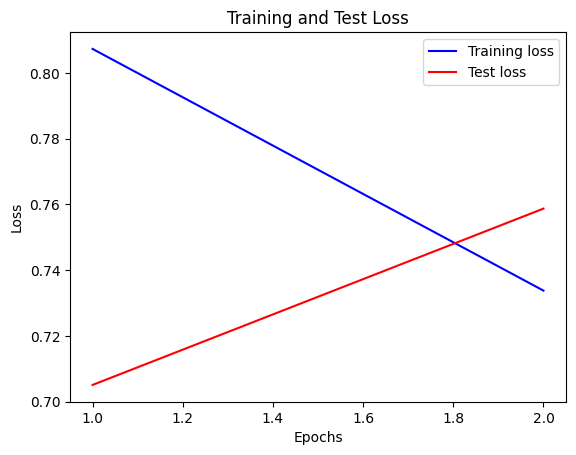

In [61]:
plot_lc(train_loss, test_loss)

# BERT

In [71]:
tokenizerBERT = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(df['benefitsReview'], df['benefits'], test_size=0.25, shuffle=True)

train_encodings_bert = tokenizerBERT(list(X_train_bert), truncation=True, padding=True, return_tensors='pt')
test_encodings_bert = tokenizerBERT(list(X_test_bert), truncation=True, padding=True, return_tensors='pt')
y_train_bert_ = pd.get_dummies(y_train_bert).values
y_test_bert_ = pd.get_dummies(y_test_bert).values

In [72]:
y_train_tensor_bert = torch.tensor(np.argmax(y_train_bert_, axis=1)).long()
y_test_tensor_bert = torch.tensor(np.argmax(y_test_bert_, axis=1)).long()

In [73]:
tensor_datasets_bert =  [
    TensorDataset(train_encodings_bert['input_ids'], train_encodings_bert['attention_mask'], y_train_tensor_bert),
    TensorDataset(test_encodings_bert['input_ids'], test_encodings_bert['attention_mask'], y_test_tensor_bert)
]

loader_bert = [
    DataLoader(tensor_datasets_bert[0], batch_size=4, shuffle=True, num_workers=2),
    DataLoader(tensor_datasets_bert[1], batch_size=4, num_workers=2)
]

In [74]:
from torch.cuda.amp import GradScaler

torch.cuda.empty_cache()
model = BERT(bert_model, df['benefits'].nunique()).to(device)
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()
train_loss, test_loss, y_train_pred, y_test_pred = run_model(model, loader_bert[0], loader_bert[1], optimizer, criterion, scaler, 2)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/2, Train Loss: 0.8757, Test Loss: 0.8187, Train Accuracy: 0.6930, Test Accuracy: 0.7037


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/2, Train Loss: 0.8440, Test Loss: 0.8147, Train Accuracy: 0.7039, Test Accuracy: 0.7037


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:		 0.7036679536679536
Balanced Accuracy:	 0.3333333333333333
F1 Score:		 0.5812735843897316
Precision:		 0.4951485890192454
Recall:			 0.7036679536679536
Confusion Matrix:		


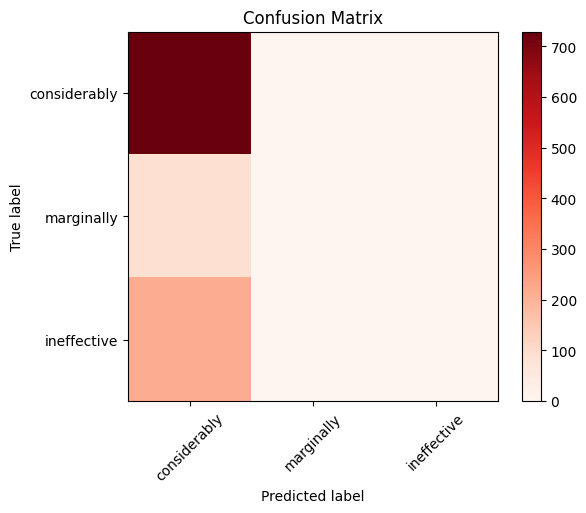

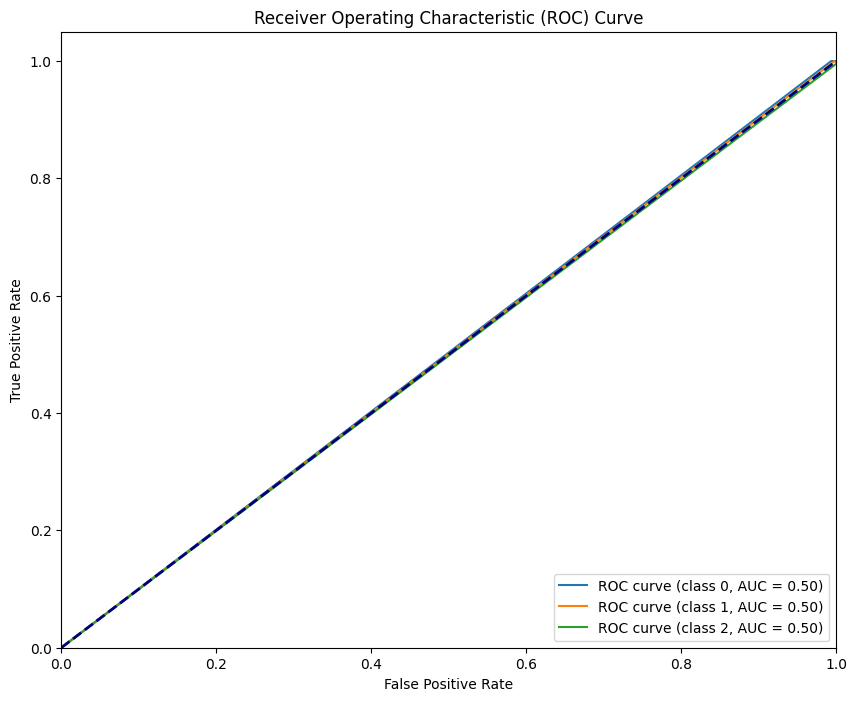

In [75]:
evaluate_model(model, loader_bert[1], device, list(df['benefits1'].unique()), df['benefits'].nunique())
torch.cuda.empty_cache()

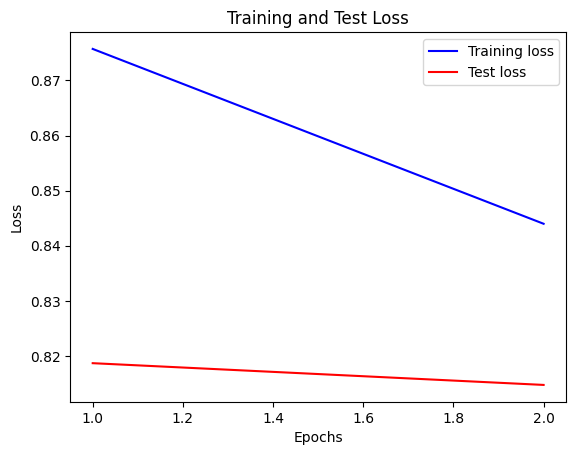

In [76]:
plot_lc(train_loss, test_loss)

# Predict side effects

In [121]:
tokenizer_ = Tokenizer()
tokenizer_.fit_on_texts(df['sideEffectsReview'])
sequences_ = tokenizer_.texts_to_sequences(df['sideEffectsReview'])
padded_sequences_ = pad_sequences(sequences_, maxlen=100)

Об'єднаємо дані

In [122]:
X = padded_sequences_.copy()

In [123]:
df['sideEffects'].unique()

array(['Mild Side Effects', 'Severe Side Effects', 'No Side Effects',
       'Extremely Severe Side Effects', 'Moderate Side Effects'],
      dtype=object)

З опису датасету зрозуміло, що для передбачення ознаки побічні ефекти, її краще розділити на 3 класи, замість наявних 5, що має допомогти збільшити точність

In [124]:
df['se'] = df['sideEffects'].apply(transform_sideEff) # se = side effects
df['se1'] = df['sideEffects'].apply(transform_sideEff) # se = side effects

In [125]:
df['se1'].unique()

array(['mild', 'severe', 'no'], dtype=object)

In [126]:
df['se'] = df['se'].astype('category').cat.codes
y = df[['se']].values
y

array([[0],
       [2],
       [1],
       ...,
       [0],
       [1],
       [0]], dtype=int8)

Після закінчення виконання preprocessing операцій, необхідно поділити датасет на тренувальну і тестувальну частини у співвідношенні 75% до 25% як зазначено в описі датасету

In [127]:
# Split dataset into training and testing parts (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

# RNN

In [129]:
rnn_model = keras.Sequential()

rnn_model.add(layers.Embedding(input_dim=15000, output_dim=128))
rnn_model.add(layers.SimpleRNN(units=64, input_shape=(df['se'].nunique(), 1)))
rnn_model.add(layers.Dense(units=df['se'].nunique(), activation='sigmoid'))

rnn_optimizer = keras.optimizers.Adam(learning_rate=0.001)

rnn_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=rnn_optimizer, metrics=['accuracy'])
rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=16)

Epoch 1/3
195/195 [==============================] - 32s 155ms/step - loss: 0.8785 - accuracy: 0.6241 - val_loss: 0.8339 - val_accuracy: 0.6535
Epoch 2/3
195/195 [==============================] - 23s 117ms/step - loss: 0.4106 - accuracy: 0.8603 - val_loss: 0.8408 - val_accuracy: 0.6622
Epoch 3/3
195/195 [==============================] - 21s 107ms/step - loss: 0.1145 - accuracy: 0.9694 - val_loss: 1.0655 - val_accuracy: 0.6245


In [130]:
y_pred_rnn = rnn_model.predict(X_test)
y_pred_labels_rnn = np.argmax(y_pred_rnn, axis=1)

33/33 [==============================] - 0s 8ms/step


Accuracy:		 0.6245173745173745
Balanced Accuracy:	 0.5672355016478859
F1 Score:		 0.6240084387092497
Precision:		 0.6243362480641539
Recall:			 0.6245173745173745
Confusion Matrix:		


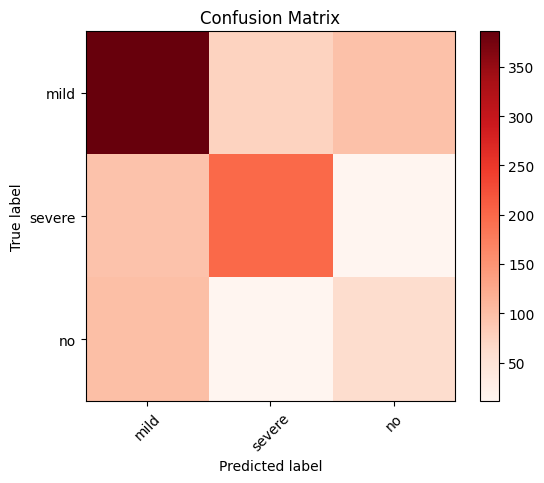

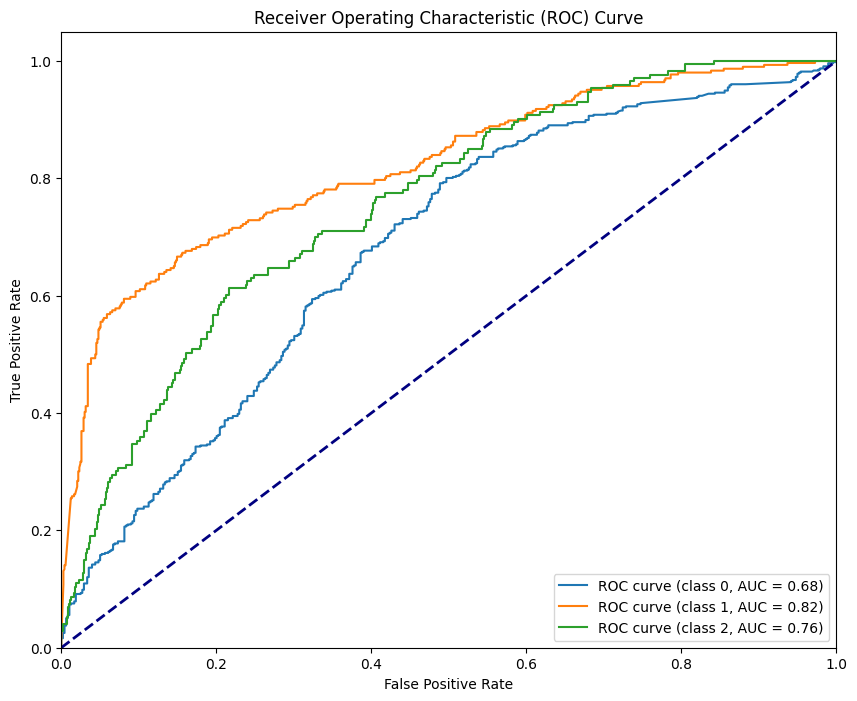

In [131]:
plot_metrics(y_test, y_pred_labels_rnn, y_pred_rnn, list(df['se1'].unique()), df['se'].nunique())

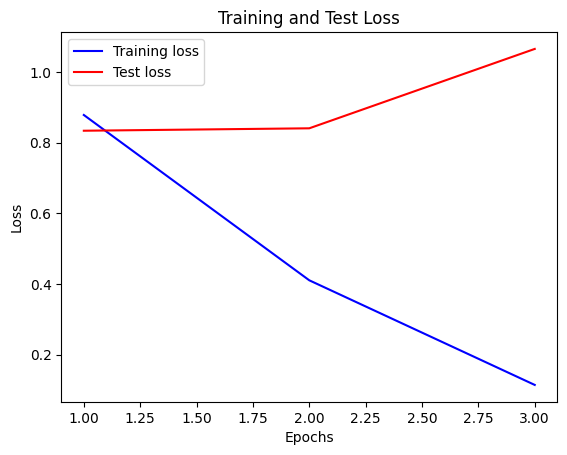

In [132]:
# Extract loss values from the history object
train_loss_rnn = rnn_history.history['loss']
val_loss_rnn = rnn_history.history['val_loss']

plot_lc(train_loss_rnn, val_loss_rnn)

# GRU

In [133]:
gru_model = keras.Sequential()

gru_model.add(layers.Embedding(input_dim=15000, output_dim=64))
gru_model.add(layers.GRU(64, return_sequences=True))
gru_model.add(layers.Dropout(0.2))
gru_model.add(layers.GRU(32))
gru_model.add(layers.Dropout(0.2))
gru_model.add(layers.Dense(df['se'].nunique(), activation='softmax'))

gru_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

gru_model.compile(optimizer=gru_optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

gru_history = gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=16)

Epoch 1/3
195/195 [==============================] - 28s 123ms/step - loss: 0.8501 - accuracy: 0.6273 - val_loss: 0.7264 - val_accuracy: 0.6708
Epoch 2/3
195/195 [==============================] - 11s 55ms/step - loss: 0.5236 - accuracy: 0.7972 - val_loss: 0.7458 - val_accuracy: 0.6931
Epoch 3/3
195/195 [==============================] - 8s 38ms/step - loss: 0.2851 - accuracy: 0.9051 - val_loss: 0.8587 - val_accuracy: 0.6892


In [134]:
y_pred_gru = gru_model.predict(X_test)
y_pred_labels_gru = np.argmax(y_pred_gru, axis=1)

33/33 [==============================] - 1s 6ms/step


Accuracy:		 0.6891891891891891
Balanced Accuracy:	 0.6440622058042945
F1 Score:		 0.6867348455752335
Precision:		 0.6855792093109909
Recall:			 0.6891891891891891
Confusion Matrix:		


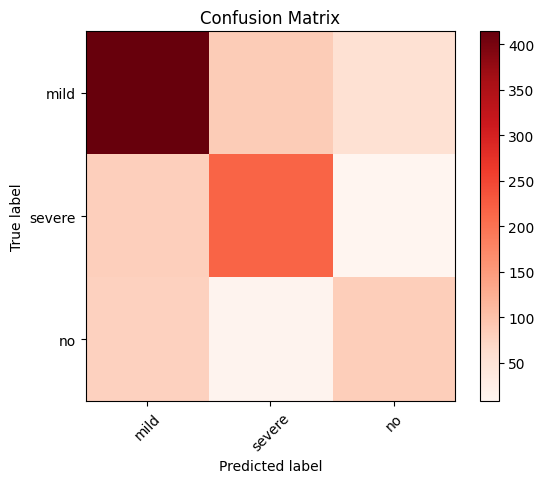

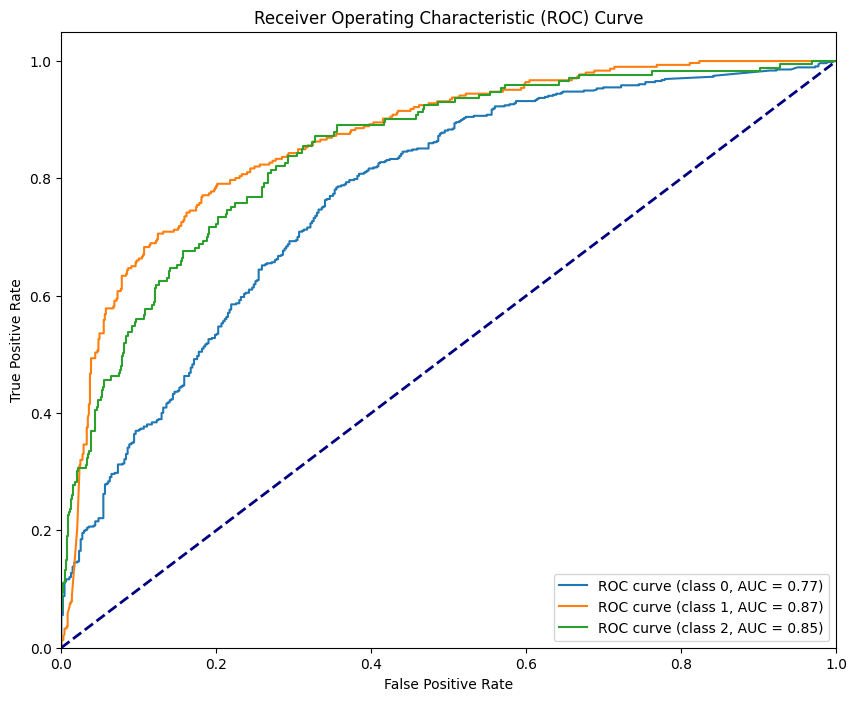

In [135]:
plot_metrics(y_test, y_pred_labels_gru, y_pred_gru, list(df['se1'].unique()), df['se'].nunique())

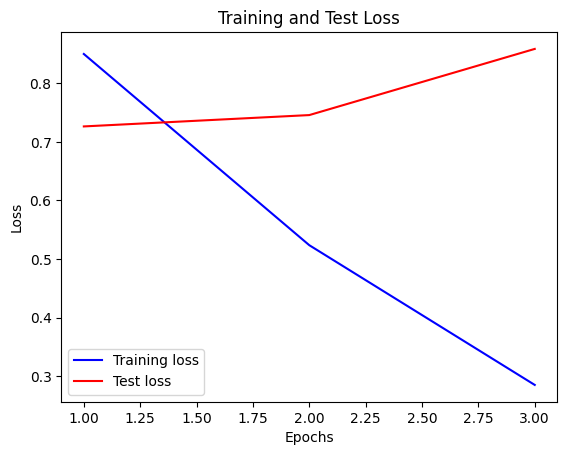

In [136]:
# Extract loss values from the history object
train_loss_lstm = gru_history.history['loss']
val_loss_lstm = gru_history.history['val_loss']

plot_lc(train_loss_lstm, val_loss_lstm)

# LSTM

In [137]:
# Create a sequential model
lstm_model = keras.Sequential()

# Add an embedding layer with 15,000 input dimensions and 64 output dimensions
lstm_model.add(layers.Embedding(input_dim=15000, output_dim=128))
# Add an LSTM layer with 64 units, set to return sequences
lstm_model.add(layers.LSTM(128, return_sequences=True))
# Add another LSTM layer with 32 units
lstm_model.add(layers.LSTM(64))
# Add a dense layer with 10 units (for 10 classes)
lstm_model.add(layers.Dense(df['se'].nunique(), activation='softmax'))

# Define the Adam optimizer with a learning rate of 0.001
lstm_optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Compile the model with SparseCategoricalCrossentropy loss and Adam optimizer
lstm_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=lstm_optimizer, metrics=['accuracy'])

# Train the model using X_train and y_train, and validate using X_test and y_test
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=16)

Epoch 1/3
195/195 [==============================] - 19s 79ms/step - loss: 0.8156 - accuracy: 0.6386 - val_loss: 0.6812 - val_accuracy: 0.7114
Epoch 2/3
195/195 [==============================] - 8s 39ms/step - loss: 0.4844 - accuracy: 0.8159 - val_loss: 0.6797 - val_accuracy: 0.7181
Epoch 3/3
195/195 [==============================] - 5s 24ms/step - loss: 0.2765 - accuracy: 0.9076 - val_loss: 0.8242 - val_accuracy: 0.7066


In [138]:
y_pred_lstm = lstm_model.predict(X_test)
y_pred_labels_lstm = np.argmax(y_pred_lstm, axis=1)

33/33 [==============================] - 1s 4ms/step


Accuracy:		 0.7065637065637066
Balanced Accuracy:	 0.6776465853859869
F1 Score:		 0.7056368300493973
Precision:		 0.7054297080055706
Recall:			 0.7065637065637066
Confusion Matrix:		


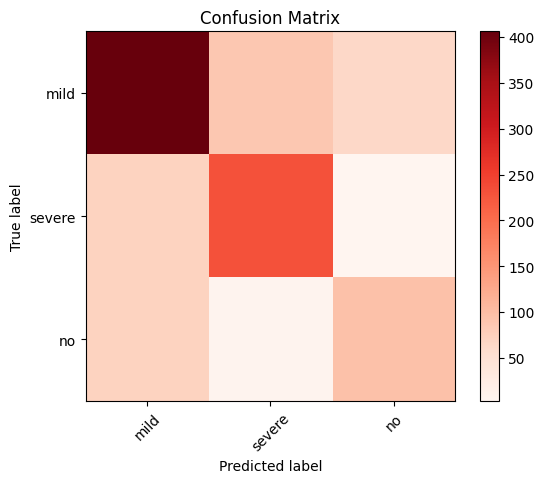

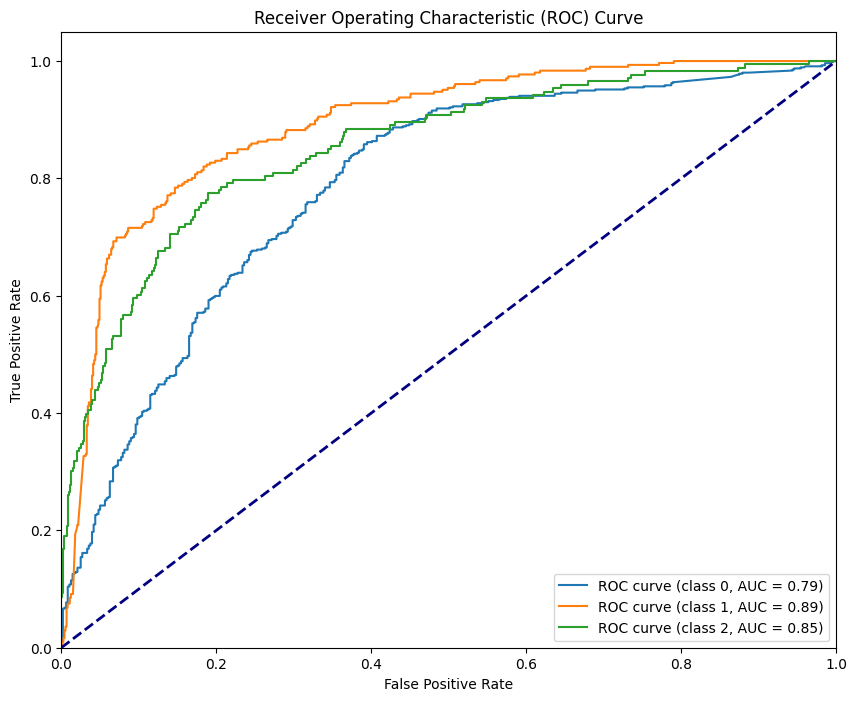

In [139]:
plot_metrics(y_test, y_pred_labels_lstm, y_pred_lstm, list(df['se1'].unique()), df['se'].nunique())

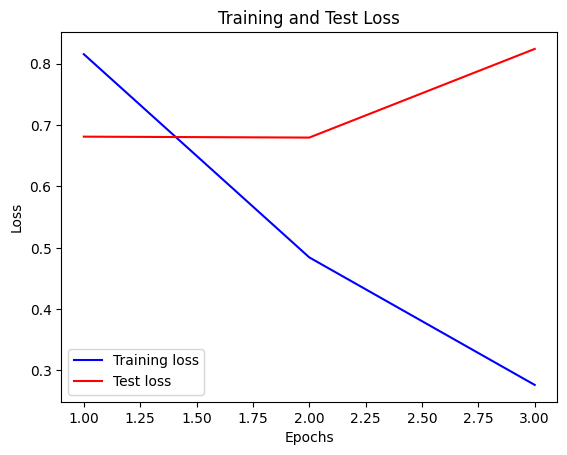

In [140]:
# Extract loss values from the history object
train_loss_lstm = lstm_history.history['loss']
val_loss_lstm = lstm_history.history['val_loss']

plot_lc(train_loss_lstm, val_loss_lstm)

# GPT

In [ ]:
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
gpt_tokenizer.pad_token = '[PAD]'

gpt_model = GPT2Model.from_pretrained('gpt2').to(device)
gpt_model.resize_token_embeddings(len(gpt_tokenizer))

X_train_gpt, X_test_gpt, y_train_gpt, y_test_gpt = train_test_split(df['sideEffectsReview'], df['se'], test_size=0.25, shuffle=True)

train_inputs_gpt = gpt_tokenizer([str(i) for i in X_train_gpt.values] , return_tensors='pt', truncation=True, padding="max_length", max_length=512)
test_inputs_gpt = gpt_tokenizer([str(i) for i in X_test_gpt.values], return_tensors='pt', truncation=True, padding="max_length", max_length=512)
y_train_gpt_ = pd.get_dummies(y_train_gpt).values
y_test_gpt_ = pd.get_dummies(y_test_gpt).values


In [ ]:
y_train_labels_gpt = np.argmax(y_train_gpt_, axis=1)
y_test_labels_gpt = np.argmax(y_test_gpt_, axis=1)
y_train_tensor_gpt = torch.tensor(y_train_labels_gpt).long()
y_test_tensor_gpt = torch.tensor(y_test_labels_gpt).long()

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import GradScaler, autocast

tensor_datasets_gpt = [
    TensorDataset(train_inputs_gpt['input_ids'], train_inputs_gpt['attention_mask'], y_train_tensor_gpt),
    TensorDataset(test_inputs_gpt['input_ids'], test_inputs_gpt['attention_mask'], y_test_tensor_gpt)
]

loader_gpt = [
    DataLoader(tensor_datasets_gpt[0], batch_size=4, shuffle=True, num_workers=2),
    DataLoader(tensor_datasets_gpt[1], batch_size=4, num_workers=2)
]



In [ ]:
from torch.cuda.amp import GradScaler

torch.cuda.empty_cache()
model = GPT2(gpt_model, df['se'].nunique()).to(device)
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()
train_loss, test_loss, y_train_pred, y_test_pred = run_model(model, loader_gpt[0], loader_gpt[1], optimizer, criterion, scaler, 2)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/2, Train Loss: 0.9216, Test Loss: 0.8024, Train Accuracy: 0.6279, Test Accuracy: 0.6670


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/2, Train Loss: 0.7791, Test Loss: 0.7904, Train Accuracy: 0.6749, Test Accuracy: 0.6612


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy:		 0.6611969111969112
Balanced Accuracy:	 0.544902814802502
F1 Score:		 0.6133144697332918
Precision:		 0.688047166768097
Recall:			 0.6611969111969112
Confusion Matrix:		


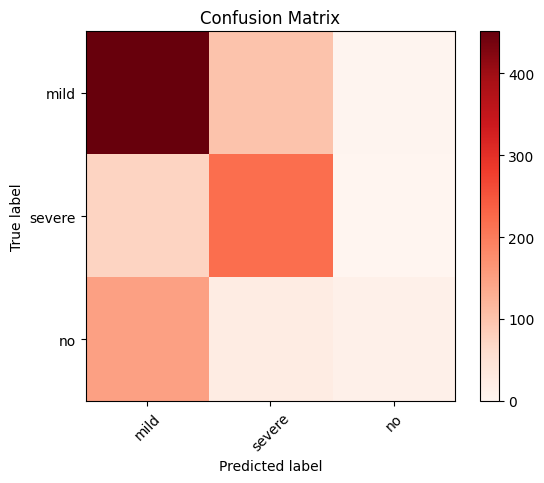

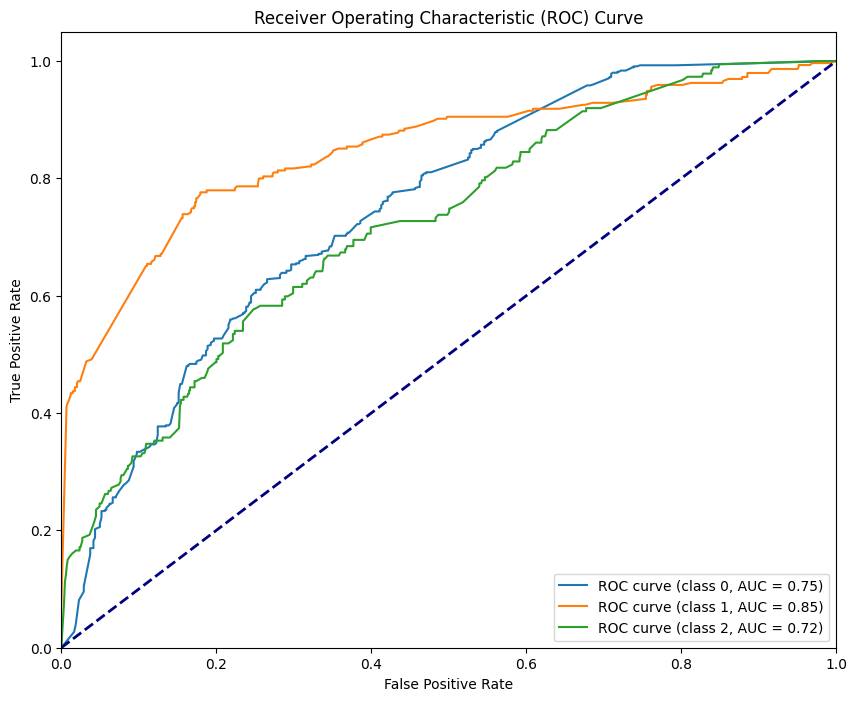

In [ ]:
evaluate_model(model, loader_gpt[1], device, list(df['se1'].unique()), df['se'].nunique())
torch.cuda.empty_cache()

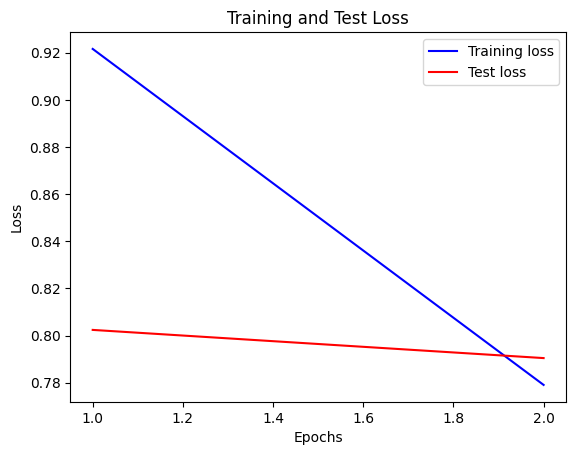

In [ ]:
plot_lc(train_loss, test_loss)

# BERT

In [35]:
from transformers import AutoTokenizer, BertModel, BertTokenizer

tokenizerBERT = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(df['sideEffectsReview'], df['se'], test_size=0.25, shuffle=True)

train_encodings_bert = tokenizerBERT(list(X_train_bert), truncation=True, padding=True, return_tensors='pt')
test_encodings_bert = tokenizerBERT(list(X_test_bert), truncation=True, padding=True, return_tensors='pt')
y_train_bert_ = pd.get_dummies(y_train_bert).values
y_test_bert_ = pd.get_dummies(y_test_bert).values

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [36]:
y_train_tensor_bert = torch.tensor(np.argmax(y_train_bert_, axis=1)).long()
y_test_tensor_bert = torch.tensor(np.argmax(y_test_bert_, axis=1)).long()

In [38]:
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import GradScaler, autocast

tensor_datasets_bert =  [
    TensorDataset(train_encodings_bert['input_ids'], train_encodings_bert['attention_mask'], y_train_tensor_bert),
    TensorDataset(test_encodings_bert['input_ids'], test_encodings_bert['attention_mask'], y_test_tensor_bert)
]

loader_bert = [
    DataLoader(tensor_datasets_bert[0], batch_size=4, shuffle=True, num_workers=2),
    DataLoader(tensor_datasets_bert[1], batch_size=4, num_workers=2)
]

In [43]:
from torch.cuda.amp import GradScaler

torch.cuda.empty_cache()
model = BERT(bert_model, df['se'].nunique()).to(device)
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()
train_loss, test_loss, y_train_pred, y_test_pred = run_model(model, loader_bert[0], loader_bert[1], optimizer, criterion, scaler, 2)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/2, Train Loss: 1.1290, Test Loss: 1.1615, Train Accuracy: 0.4615, Test Accuracy: 0.1766


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/2, Train Loss: 1.1454, Test Loss: 1.1336, Train Accuracy: 0.4458, Test Accuracy: 0.5386


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:		 0.5386100386100386
Balanced Accuracy:	 0.3333333333333333
F1 Score:		 0.37709460670564815
Precision:		 0.29010077369150733
Recall:			 0.5386100386100386
Confusion Matrix:		


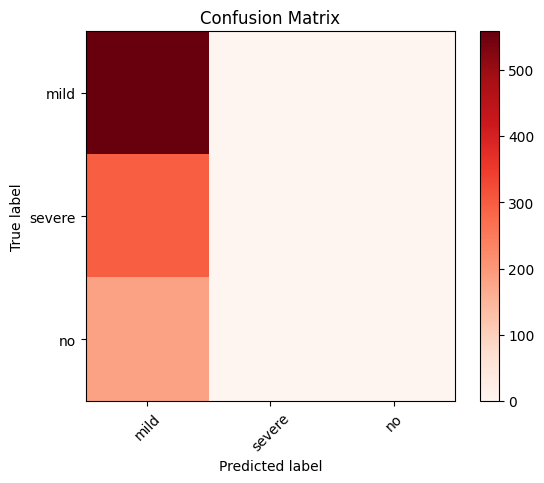

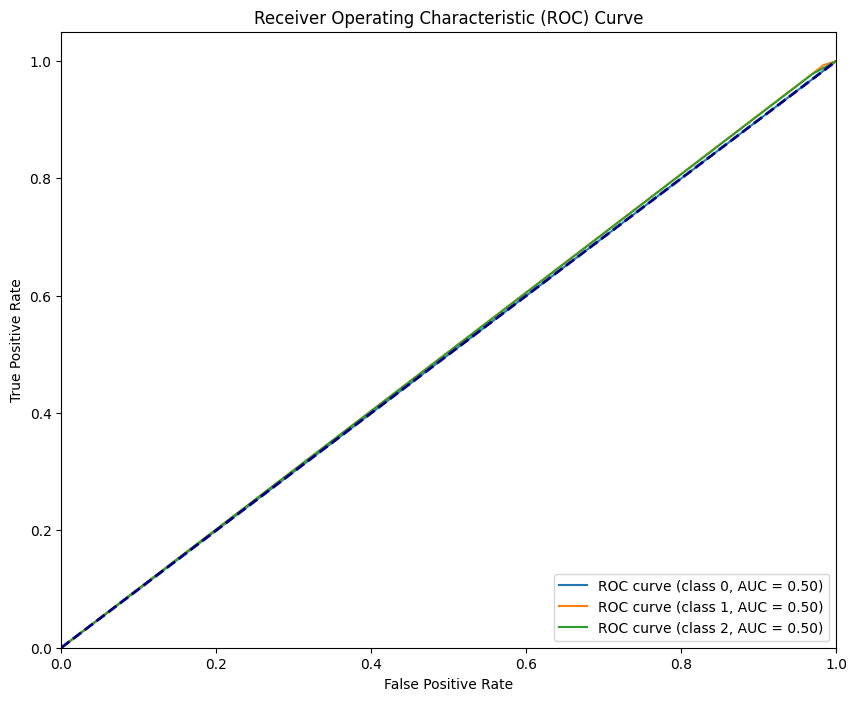

In [44]:
evaluate_model(model, loader_bert[1], device, list(df['se1'].unique()), df['se'].nunique())
torch.cuda.empty_cache()

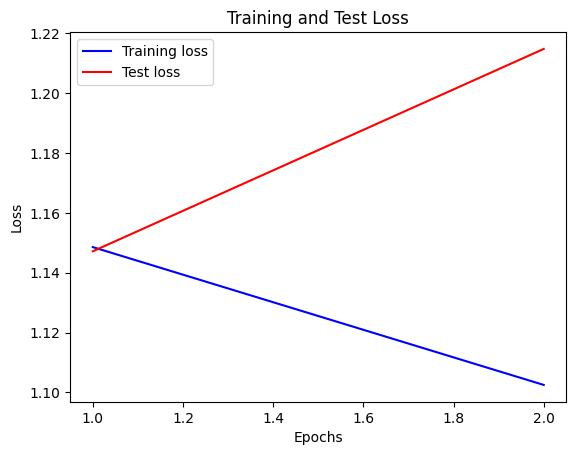

In [ ]:
plot_lc(train_loss, test_loss)

# Висновок

Під час виконання лабораторної роботи був проведений семантичний аналіз над заданим набором даних, для подальшого передбачення визначених ознак за допомогою моделей RNN, GRU, LSTM, GPT та BERT. Створені моделі показали середні показники точності, не зважаючи на виконані видозмінення датасету. Все це відбулося через незбалансованість датасету, адже зміна гіперпараметрів самих моделей відігравала мінімальну роль у збільшенні точності передбачень.